# Spectral densities from diagonalization of Hilbert matrix

We know that for a non-subtracted spectral density, the diagonalization of the Hilbert matrix leads to the following expression:

$$ \bar{\rho}(\omega) =  \int_0^{+\infty}dr\, \frac{a\sum_{n=1}^{+\infty}C(an)\bar{v}_r(n, a)}{|\lambda_s|}v_r(\omega, a).$$

In case of a smeared spectral density, we simply need to integrate with the kernel, obtaining:

$$ \bar{\rho}_\kappa =  \int_0^{+\infty}dr\, \frac{a\sum_{n=1}^{+\infty}C(an)\bar{v}_r(n, a)}{|\lambda_s|}\tilde{\kappa}_a(r), \quad \tilde{\kappa}_a = \int_0^{+\infty} d\omega\, \kappa(\omega)v_r(\omega, a). $$

## Definition of functions

In [336]:
import numpy as np
import scipy as sp
import mpmath as mp
import matplotlib.pyplot as plt
import time
from matplotlib.ticker import MultipleLocator, LogLocator, LogitLocator, NullFormatter
from jackknife import *
from corr_fits import *
from spectral_density import *

mpmath.mp.dps = 15
plt.style.use('my_style.mplstyle')

class DiscreteSpectralDensity:
    def __init__(self, mod:str = "numpy"):
        self.ker_np = {
            "Gaussian": lambda w, w0, sigma: sp.stats.norm(w0, sigma).pdf(w),
            "Breit-Wigner": lambda w, w0, sigma: sigma/(np.pi*((w-w0)**2 + sigma**2))
        }
        self.ker_mp = {
            "Gaussian": lambda w, w0, sigma: mp.exp(-(w-w0)**2/(2* sigma**2))/mp.sqrt(2*mp.pi* sigma**2),
            "Breit-Wigner": lambda w, w0, sigma: mp.mpf(sigma)/(mp.pi*((mp.mpf(w)-mp.mpf(w0))**2 + mp.mpf(sigma)**2))
        }
        match mod:
            case "numpy":
                self.ker = self.ker_np
                self.v_s = self.v_s_np
                self.v_bar = self.v_bar_np
                self.mellin = self.mellin_np
                self.rho = self.rho_np
                self.delta_c_hat = self.delta_c_hat_np
                self.delta_rho_hat = self.delta_rho_hat_np
            case "mpmath":
                self.ker = self.ker_mp
                self.v_s = self.v_s_mp
                self.v_bar = self.v_bar_mp
                self.mellin = self.mellin_mp
                self.rho = self.rho_mp
            case _:
                print("Module not available")

    # Numpy functions
    def v_s_np(self, s:float, w:float):
        lambda_s = gamma(0.5+s*1.0j)
        N_s = np.sqrt(2.0 * np.pi) * lambda_s * gamma(-2.0j * s)/gamma(1.5 - s * 1.0j)
        z = np.exp(-w)
        return (complex(mp.hyp2f1(0.5 + s * 1.0j, 1.5 + s * 1.0j, 2, z)) * (1-z)**(-0.5 + s * 1.0j) * z * np.abs(lambda_s) ** 2 / np.abs(N_s)).real
        
    def v_bar_np(self, s:float, n:int):
        lambda_s = gamma(1/2+s*1.0j)
        N_s = np.sqrt(2. * np.pi) * lambda_s * gamma(-2.0j * s)/gamma(1.5 - s * 1.0j)
        return np.abs(lambda_s) ** 3. * complex(mp.hyp3f2(1-n, 0.5 + s * 1.0j, 0.5 - s * 1.0j, '1', '2', '1')).real / np.abs(N_s)
        
    def mellin_np(self, s:float, m:int, corr:np.ndarray, jacobian:bool = False):
        coeff = np.array([self.v_bar(s, i) * (i ** (m)) for i in range(1, len(corr)+1)])
        if jacobian:
            return corr @ coeff, coeff
        return corr @ coeff
    
    def rho_np(self, w, corr, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            #f = lambda s: self.mellin(s, m, corr)/np.abs(sp.special.gamma(0.5+1j*s)) * self.v_s(s, w)
            f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * self.v_s(s, w)
            return sp.integrate.quad(f, 0, rmax)
        else:
            #f = lambda s: self.mellin(s, m, corr)/np.abs(sp.special.gamma(0.5+1j*s)) * mp.fp.quad(lambda ww: self.v_s(s, ww) * self.ker[ker](ww, w, sigma), [0, +np.inf])
            f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * mp.fp.quad(lambda ww: self.v_s(s, ww) * self.ker[ker](ww, w, sigma), [0, +np.inf])
            return (corr*(np.arange(1, len(corr)+1))**m) @ sp.integrate.quad_vec(f, 0, rmax)[0] # (corr*(np.arange(1, len(corr)+1))) @ 

    def delta_c_hat_np(self, s:float, m:int, tmax:int, c_tmax:float, w0:float, Ninf:int):
        nvals = np.arange(tmax+1, Ninf+1)
        v = np.array([np.abs(self.v_bar(s, j)) for j in nvals])
        return c_tmax * np.exp(w0*tmax) * np.sum(np.flip((np.exp(-w0 * nvals) * nvals**m) * v))
       
    def delta_rho_hat_np(self, w, tmax, c_tmax, w0, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
            f = lambda s: self.delta_c_hat(s, m, tmax, c_tmax, w0, 3*tmax)/np.abs(sp.special.gamma(0.5+1j*s)) * np.abs(self.v_s(s, w))
            return sp.integrate.quad(f, 0, rmax)
        else:
            f = lambda s: self.delta_c_hat(s, m, tmax, c_tmax, w0, 3*tmax)/np.abs(sp.special.gamma(0.5+1j*s)) * np.abs(mp.fp.quad(lambda ww: self.v_s(s, ww) * self.ker[ker](ww, w, sigma), [0, +np.inf]))
            return sp.integrate.quad(f, 0, rmax)
        
    # Mpmath functions
    def v_s_mp(self, s:float, w:float):
        a1 = mpmath.mpc('1/2', str(s))
        a2 = mpmath.mpc('3/2', str(s))
        lambda_s = mpmath.gamma(a1)
        N_s = mpmath.sqrt(mpmath.mpf('2') * mpmath.pi) * lambda_s * \
            mpmath.gamma(mpmath.mpc('0', mpmath.mpf('-2') * mpmath.mpf(str(s))))/mpmath.gamma(mpmath.mpc('3/2', mpmath.mpf(str(-s))))
        z = mpmath.exp(-mpmath.mpf(str(w)))
        return (mpmath.hyp2f1(a1, a2, mpmath.mpf('2'), z) * (1-z)**(mpmath.mpc('-1/2', str(s))) * z * mpmath.fabs(lambda_s) ** (mpmath.mpf('2')) / mpmath.fabs(N_s)).real  
        
    def v_bar_mp(self, s:float, n:int):
        a1 = int(1-n)
        a2 = mpmath.mpc('1/2', str(s))
        a3 = mpmath.mpc('1/2', str(-s))
        lambda_s = mpmath.gamma(a2)
        N_s = mpmath.sqrt(mpmath.mpf('2') * mpmath.pi) * lambda_s * \
            mpmath.gamma(mpmath.mpc('0', mpmath.mpf('-2') * mpmath.mpf(str(s))))/mpmath.gamma(mpmath.mpc('3/2', mpmath.mpf(str(-s))))
        return mpmath.fabs(lambda_s) ** (mpmath.mpf('3')) * (mpmath.hyp3f2(a1, a2, a3, '1', '2', '1')).real / (mpmath.fabs(N_s))
    
    def mellin_mp(self, s:float, m:int, corr:np.ndarray, jacobian:bool = False):
        coeff = mp.matrix([self.v_bar(s, mpmath.mpf(i)) * (mpmath.mpf(i) ** (mpmath.mpf(m))) for i in range(1, len(corr)+1)], dtype = float)
        
        if jacobian:
            return corr.T @ coeff, coeff
        return (mp.matrix(corr).T * coeff)[0, 0]
    
    def rho_mp(self, w, corr, rmax, m = 0, ker = "None", sigma = 0.0):
        if ker == "None":
           #f = lambda s: np.array([self.v_bar(s, i) for i in range(1, len(corr)+1)])/np.abs(sp.special.gamma(0.5+1j*s)) * self.v_s(s, w)
            f = lambda s: self.mellin(s, m, corr)/mp.fabs(mp.gamma(mp.mpc("1/2", str(s)))) * self.v_s(s, w)
            return mp.quad(f, [0, rmax])
        else:
            f = lambda ww, s: (self.mellin(s, m, corr)/mp.fabs(mp.gamma(mp.mpc("1/2", str(s)))) * self.v_s(s, ww) * self.ker[ker](ww, mp.mpf(str(w)), mp.mpf(str(sigma))))
            return mp.quad(f, [0, +mp.inf], [0, rmax], verbose = True)
            #return sp.integrate.dblquad(f, 0, +np.inf, 0, rmax)

class ContinuumSpectralDensity:
    def __init__(self) -> None:
        self.kernels_mellin = {
            "None": lambda s, w, sigma: np.sqrt(2. * np.pi) * self.u_s(s, w),
            "Gaussian": lambda s, w, sigma: 2**(-1.25+s*0.5j)*sigma**(-1.5+s*1.0j)*complex(sigma*mpmath.gamma(0.25+s*0.5j)*mpmath.hyp1f1(0.25-s*0.5j, 0.5, -w**2/(2*sigma**2)) + \
                                                                                   np.sqrt(2)*w*mpmath.gamma(0.75+s*0.5j)*mpmath.hyp1f1(0.75-s*0.5j, 1.5, -w**2/(2*sigma**2)))/np.sqrt(np.pi), 
            "Tikhonov": lambda s, w, a: np.sqrt(2. * np.pi) * self.u_s(s, w) * np.abs(gamma(0.5 + s * 1.0j))**2.0 / (np.abs(gamma(0.5 + s * 1.0j))**2.0 + a),
            "Breit-Wigner": lambda s, w, sigma: -np.sqrt(2.*np.pi) * self.u_s(s, np.sqrt(w**2.0 + sigma**2.0)) * complex(mpmath.sin((-0.5+s*1.0j)*mpmath.acos(-w/mpmath.sqrt(w**2.0 + sigma**2.0)))/\
                                        mpmath.sin((0.5+s*1.0j)*np.pi))
        }

    def u_s(self, s:float, w:float) -> complex:
        return (w**(-0.5 + s*1.0j)/np.sqrt(2*np.pi))

    def mellin(self, s:np.ndarray, par:np.ndarray, m:float, t_max = +np.inf):
        if not isinstance(s, (np.ndarray, list)):
            s = np.array([s])
        else:
            s = np.array(s)
        nexp = int(np.floor(len(par)/2))
        r = np.zeros(len(s), dtype=complex)
        J = np.zeros((len(par), len(s)), dtype=complex)
    
        for i in range(len(s)):
            tr = lambda w, m: complex(mpmath.gammainc(m + 0.5 + s[i] * 1.0j, 0, w * t_max)) * (w ** (-m)) * self.u_s(s[i], w).conjugate()
            for ni in range(nexp):
                r[i] += par[2*ni] * tr(par[2*ni+1], m)
                J[2*ni, i] = tr(par[2*ni+1], m)
                J[2*ni+1, i] = -par[2*ni]*tr(par[2*ni+1], m+1)
    
        if len(s) == 1:
            return r[0], np.reshape(J, (len(par), ))
        return r, J

    #def rho_mellin(self, w, par, alpha, n, t_max = +np.inf, ker = "None", sigma = 0, print_J = False, cov_par = 0):
    #    if not isinstance(w, (np.ndarray, list)):
    #        w = np.array([w])
    #    else:
    #        w = np.array(w)
    
    #    r = np.zeros(len(w))
    #    J = np.zeros((len(par), len(w)))
    #    for i in range(len(w)):
    #        f = lambda s: (2. * self.mellin(s, par, n, t_max)[0] * self.kernels_mellin[ker](s, w[i], sigma) * (complex(mp.gamma(n + 0.5 + s * 1.0j)).conjugate()/ (np.abs(complex(mpmath.gamma(n + 0.5 + s * 1.0j)))**2 + alpha)) / np.sqrt(2 * np.pi)).real
    #        r[i] = quad(f, 0, +np.inf)[0]
    #        f = lambda s: np.reshape((np.array(2. * mellin(s, par, n, t_max)[1] * kernels_mellin[ker](s, w[i], sigma) * (complex(mpmath.gamma(n + 0.5 + s * 1.0j)).conjugate()/ (np.abs(complex(mpmath.gamma(n + 0.5 + s * 1.0j)))**2 + alpha)) / np.sqrt(2 * np.pi), dtype = complex)).real, (len(par),))
    #        J[:, i] = quad_vec(f, 0, +np.inf)[0]

    #    if len(w) == 1:
    #        if not print_J:
    #            return r[0], np.sqrt(np.diagonal(J.T @ cov_par @ J))[0]
    #        else:
    #            return r[0], np.reshape(J, (len(par),))
    #    if not print_J:
    #        return r, np.sqrt(np.diagonal(J.T @ cov_par @ J))
    #    else:
    #        return r, J

SDnumpy = DiscreteSpectralDensity("numpy")
SDmpmath = DiscreteSpectralDensity("mpmath")
SDcont = ContinuumSpectralDensity()

M_PI = 270*0.065/197.3

## Single exponential

### Study of the "discrete Mellin transform"

We begin from the study of the numerator of the first fraction, which is the discrete analogue of the Mellin transform. Taking into account also the case of subtracted spectral densities, we study:
$$ \tilde{C}_a (r) = a\sum_{n=1}^{+\infty}C(an)(an)^m\bar{v}_r(n, a).$$
Since we have a correlator with a finite temporal extent, we will compute:
$$ \hat{C}_a (r) = a\sum_{n=1}^{t_\mathrm{max}/a}C(an)(an)^m\bar{v}_r(n, a). $$
Following the continuum, we can obtain a bound for this truncation:
$$ \Delta\hat{C}_a(m, r, t_\mathrm{max})  = C(t_\mathrm{max}) e^{\omega_0 t_\mathrm{max}} \sum_{n = t_\mathrm{max}/a+1}^{+\infty}e^{-\omega_0 a n}(an)^m|\bar{v}_r(n, a)|. $$
The sum to $+\infty$ can be easily approximated to floating point precision thanks to the exponential decay of the terms in the sum.

In [ ]:
w0, m, Ninf = 0.3, 0, 500
par1 = np.array([1, w0])
s = np.linspace(0.001, 25, 201)

tmax = np.array([6//w0, 12//w0, 18//w0, 24//w0, Ninf])
c_hat_a = np.array([[SDnumpy.mellin(si, m, np.exp(-w0 * np.arange(1, tm + 1))) for si in s] for tm in tmax])
delta_c_a = np.array([[SDnumpy.delta_c_hat(si, m, tm, np.exp(-w0 * tm), w0, Ninf) for si in s] for tm in tmax])

tmax = np.array([6//w0, 12//w0, 18//w0, 24//w0, +np.inf])
c_hat = np.array([[SDcont.mellin(si, par1, m, tm)[0] for si in s] for tm in tmax])

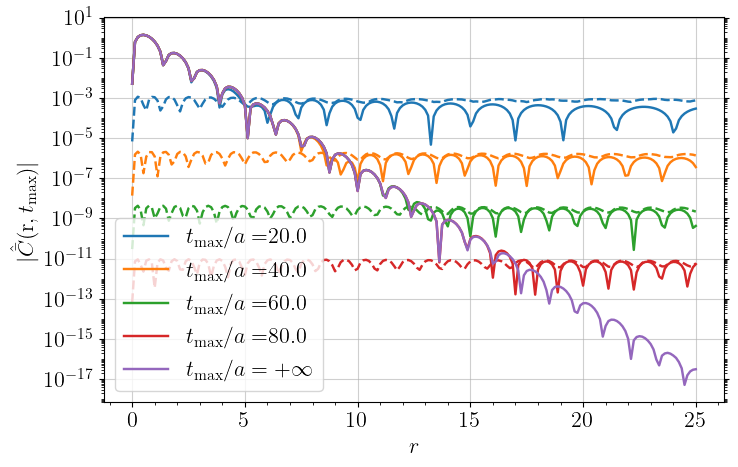

In [ ]:
for ti in range(len(tmax)):
    if tmax[ti] == +np.inf:
        line, = plt.plot(s, np.abs(c_hat_a[ti]), label = r"$t_\mathrm{max}/a = +\infty$")
    else:
        line, = plt.plot(s, np.abs(c_hat_a[ti]), label = r"$t_\mathrm{max}/a = $"+r"${}$".format(tmax[ti]))
        plt.plot(s, delta_c_a[ti], color = line.get_color(), linestyle = "dashed")
plt.semilogy()
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"$|\hat{\bar{C}}(\mathrm{r}, t_\mathrm{max})|$")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(LogLocator(10, numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=range(1, 10, 1),numticks=25))
ax.yaxis.set_minor_formatter(NullFormatter())

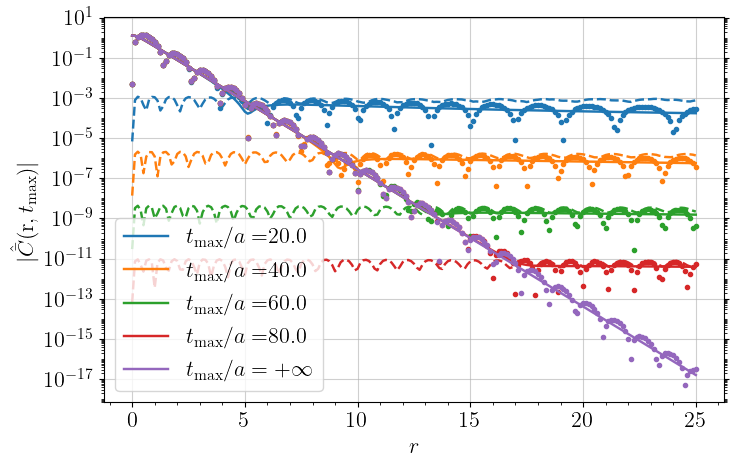

In [ ]:
for ti in range(len(tmax)):
    if tmax[ti] == +np.inf:
        line, = plt.plot(s, np.abs(c_hat_a[ti]), "o", markersize = 3)
        plt.plot(s, np.abs(c_hat[ti]), line.get_color(), label = r"$t_\mathrm{max}/a = +\infty$")
    else:
        line, = plt.plot(s, np.abs(c_hat_a[ti]), "o", markersize = 3)
        plt.plot(s, np.abs(c_hat[ti]), line.get_color(), label = r"$t_\mathrm{max}/a = $"+r"${}$".format(tmax[ti]))
        plt.plot(s, delta_c_a[ti], color = line.get_color(), linestyle = "dashed")
plt.semilogy()
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"$|\hat{\bar{C}}(\mathrm{r}, t_\mathrm{max})|$")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(LogLocator(10, numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=range(1, 10, 1),numticks=25))
ax.yaxis.set_minor_formatter(NullFormatter())

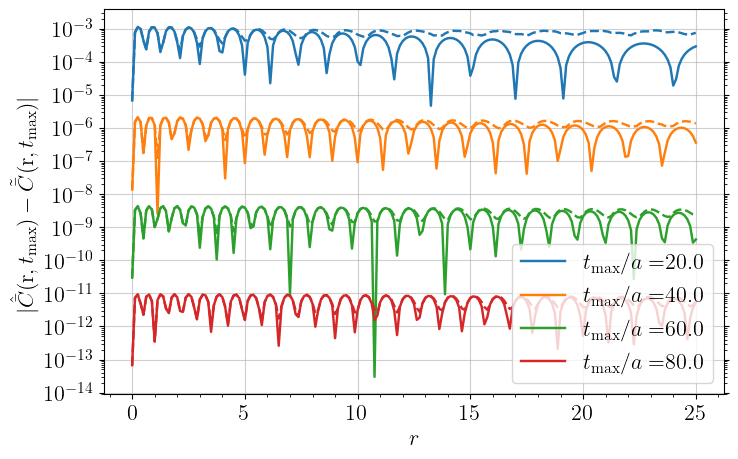

In [ ]:
for ti in range(len(tmax)):
    if tmax[ti] != +np.inf:
        line, = plt.plot(s, np.abs(c_hat_a[ti] - c_hat_a[-1]), label = r"$t_\mathrm{max}/a = $"+r"${}$".format(tmax[ti]))
        plt.plot(s, delta_c_a[ti], color = line.get_color(), linestyle = "dashed")
    else:
        break
plt.semilogy()
plt.legend()
plt.xlabel(r"$r$")
plt.ylabel(r"$|\hat{\bar{C}}(\mathrm{r}, t_\mathrm{max}) - \tilde{\bar{C}}(\mathrm{r}, t_\mathrm{max})|$")
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(LogLocator(10, numticks=15))
ax.yaxis.set_minor_locator(LogLocator(base=10.0,subs=range(1, 10, 1),numticks=25))
ax.yaxis.set_minor_formatter(NullFormatter())

Text(0, 0.5, '$|\\tilde{C}_a(\\mathrm{r})/\\Gamma(\\mathrm{r})|$')

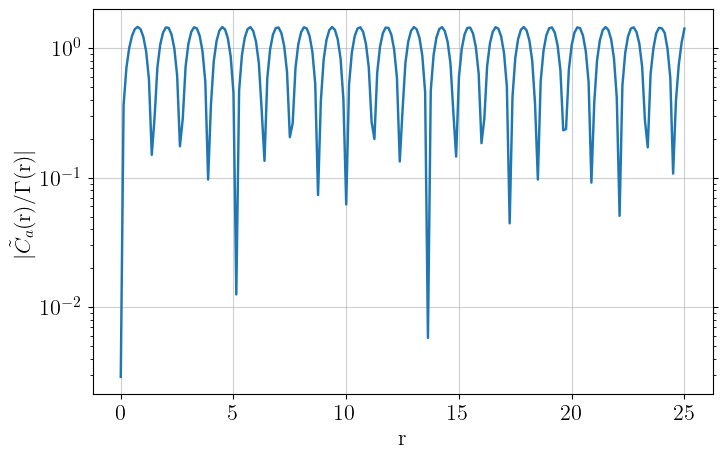

In [ ]:
plt.plot(s, np.abs(c_hat_a[-1]/sp.special.gamma(0.5+1j*s)))
plt.semilogy()
plt.xlabel("r")
plt.ylabel(r"$|\tilde{C}_a(\mathrm{r})/\Gamma(\mathrm{r})|$")

This plot shows that in the discrete case the ratio $|\tilde{C}_a(\mathrm{r})/\Gamma(\mathrm{r})|$ behaves the same as in the continuum: it oscillate, but has a maximum. Differently from the continuum case, the maximum is not in 0.

### Computation of $\hat{\rho}_a(r_\mathrm{max})$

In [ ]:
laplace_ker = {"Gaussian": lambda t, w0, sigma: 0.5*np.exp(0.5*t*(t*sigma**2-2*w0)) * sp.special.erfc((sigma**2 * t - w0)/(np.sqrt(2)*sigma)), 
               "Breit-Wigner": lambda t, w0, sigma: ((np.exp(t*complex(-w0, sigma))*(2*sp.special.expi(t*complex(w0, -sigma))+2j*np.pi) + 2*np.exp(t*complex(-w0, -sigma))*complex(mp.gammainc(0, t*complex(-w0, -sigma))))*complex(0, -1/(4*np.pi))).real}
laplace_ker_int = {"Gaussian": lambda t, w0, sigma: mp.quad(lambda w: mp.exp(-w * t) * mp.exp(-(w - w0)**2/(2*sigma**2))/mp.sqrt(2*mp.pi*sigma**2), [0, +mp.inf]),
                   "Breit-Wigner": lambda t, w0, sigma: mp.quad(lambda w: mp.exp(-w * t) * sigma / (mp.pi*((w - w0)**2 + sigma**2)), [0, +mp.inf])}

In [ ]:
laplace_ker["Breit-Wigner"](40, 3*M_PI, M_PI), laplace_ker_int["Breit-Wigner"](40, 3*M_PI, M_PI)

(0.01100183460272211, mpf('0.01100183460272211'))

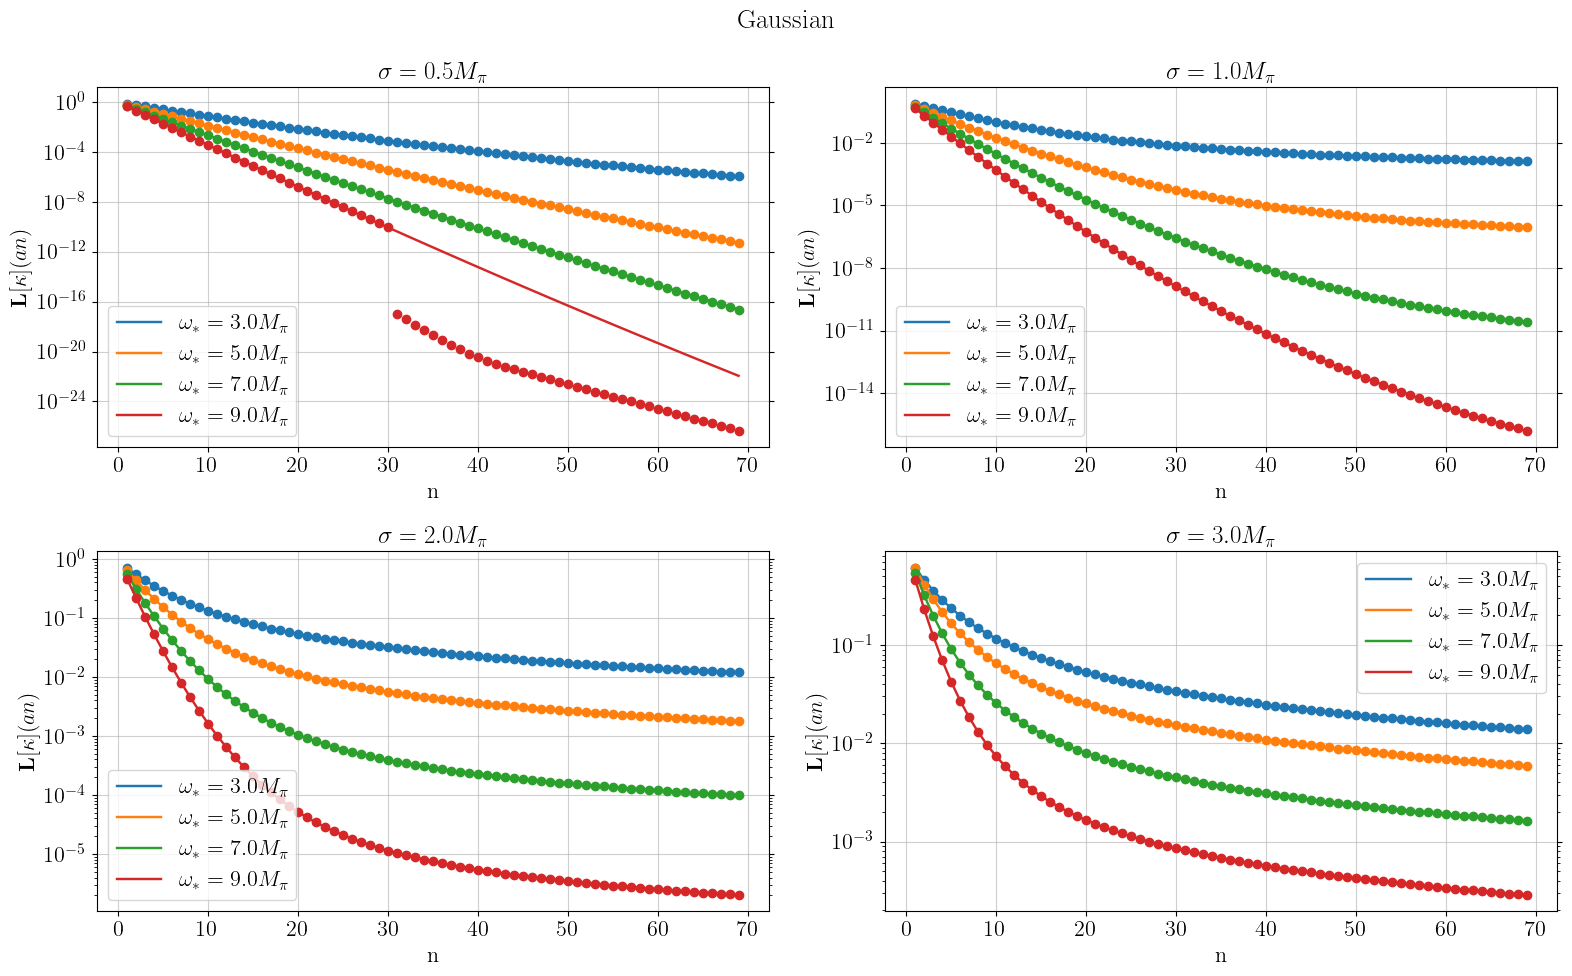

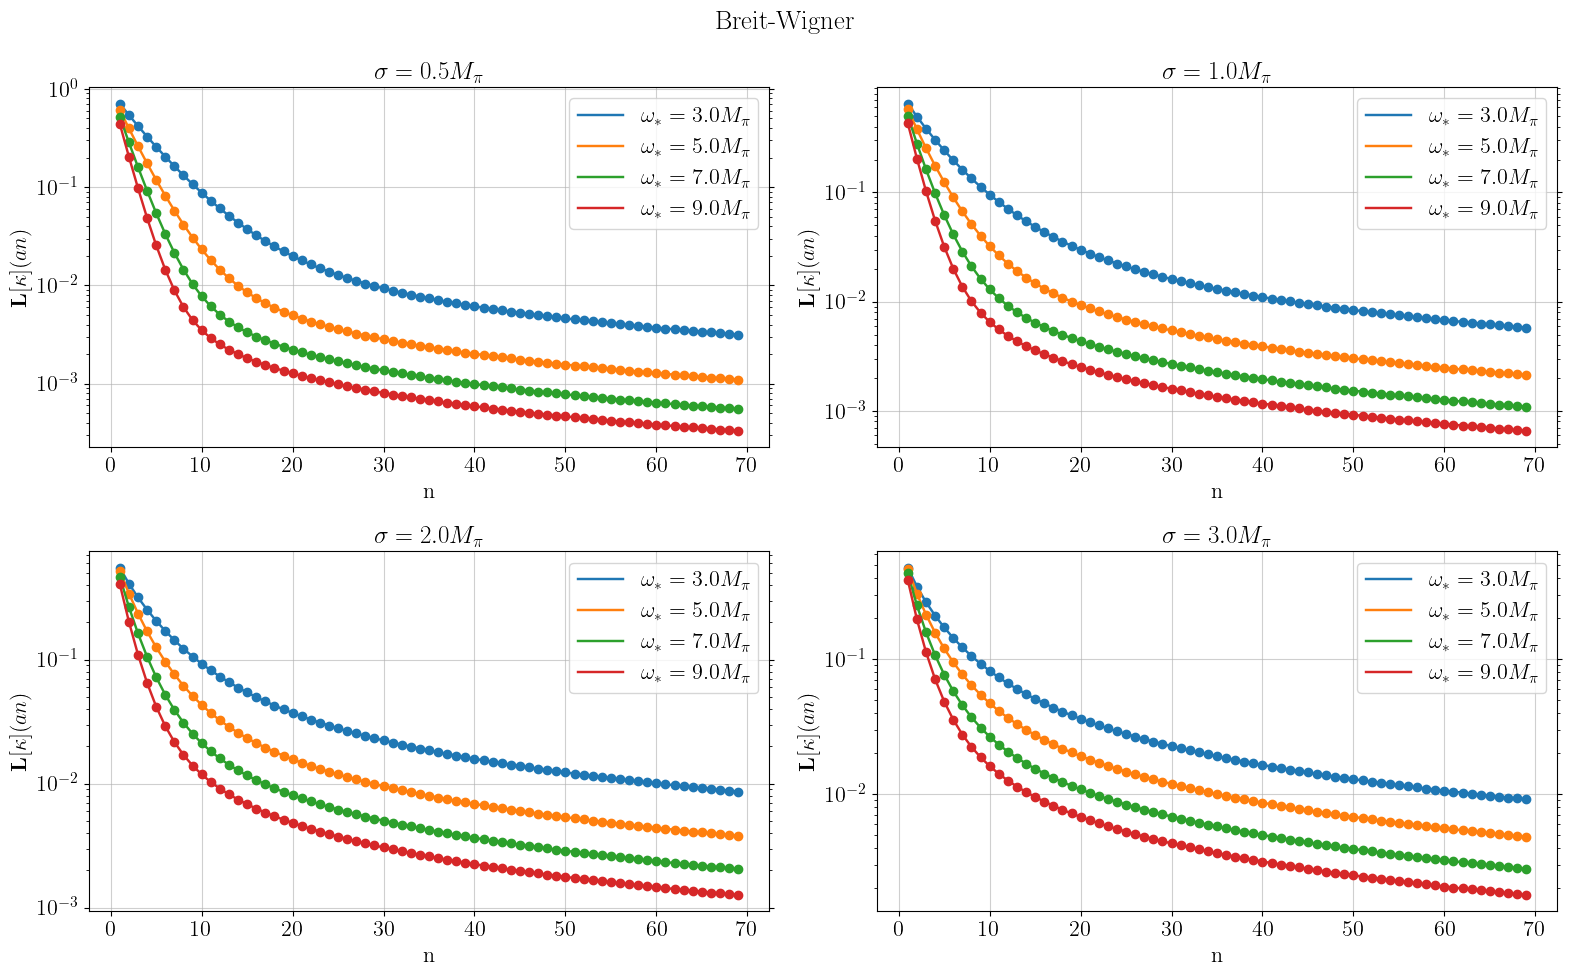

In [ ]:
ker = ["Gaussian", "Breit-Wigner"]
t, w0, sigma = np.arange(1, 70), np.array([3, 5, 7, 9])*M_PI, np.array([0.5, 1, 2, 3])*M_PI
for ki in ker:
    plt.figure(figsize=(16, 10))
    for sigi in range(len(sigma)):
        plt.subplot(2, 2, sigi+1)
        for wi in range(len(w0)):
            lnp = np.array([laplace_ker[ki](i, w0[wi], sigma[sigi]) for i in t])
            line, = plt.plot(t, lnp, label = r"$\omega_* = {}M_\pi$".format(w0[wi]/M_PI))
            lmp = np.array([laplace_ker_int[ki](i, w0[wi], sigma[sigi]) for i in t])
            plt.plot(t, lmp, "o", color = line.get_color())
        plt.semilogy()
        plt.legend()
        plt.xlabel("n")
        plt.ylabel(r"$\mathbf{L}[\kappa](an)$")
        plt.title(r"$\sigma = {}M_\pi$".format(sigma[sigi]/M_PI))
    plt.suptitle(ki)
    plt.tight_layout()
    plt.show()

OBSERVATIONS: 
1) The Laplace transform of the kernels has a power-like decay (BW slightly worse than Gaussian). This probably worsen the convergence of the summation for $v_r(\omega, a)$;
2) for the Gaussian, direct integration in mpmath to compute the Laplace transform needs higher precision for higher $t$ when $\omega^*$ is large and $\sigma$ is small. Thus, in this case, the analytic solution seems to be better;

In [ ]:
N, Ninf = [250, 500, 750, 1000], 2000
w0, sigma = 3*M_PI, M_PI
r, ker = [2], ["Gaussian", "Breit-Wigner"]
for ki in ker:
    for ri in r:
        print("Kernel: "+ki+f", r = {ri}")
        v = np.array([laplace_ker[ki](n, w0, sigma) for n in range(1, Ninf+1)])
        for ni in N:
            res_sum = SDnumpy.mellin(ri, 0, v[0:ni])
            print(f"Sum with {ni} terms: {res_sum}")
        res_int = mp.fp.quad(lambda x: SDnumpy.ker[ki](x, w0, sigma)*SDnumpy.v_s(ri, x), [0, +np.inf])
        res_int_mp = mp.quad(lambda x: SDmpmath.ker[ki](x, w0, sigma)*SDmpmath.v_s(ri, x), [0, +mp.inf])
        print(f"Results with integrals: {res_int}, {res_int_mp}")

For the time being, the sum does not converge.

In [ ]:
w0, sigma = 10*M_PI, 2*M_PI
r, ker = [2, 4, 6, 8, 10], ["Gaussian", "Breit-Wigner"]

for ki in ker:
    for ri in r:
        print("Kernel: "+ki+f", r = {ri}")
        start = time.time()
        res_mp_mp = mp.quad(lambda x: SDmpmath.ker[ki](x, w0, sigma)*SDmpmath.v_s(ri, x), [0, +mp.inf])
        end = time.time()
        print("\tMpmath function, mpmath integration: {}, time = {}".format(res_mp_mp, end-start))
        start = time.time()
        res_np_sp = sp.integrate.quad(lambda x: SDnumpy.ker[ki](x, w0, sigma)*SDnumpy.v_s(ri, x), 0, +np.inf)[0]
        end = time.time()
        print("\tFloat function, float integration (scipy): {}, err = {}, time = {}".format(res_np_sp, res_mp_mp - res_np_sp, end-start))
        start = time.time()
        res_np_np = mp.fp.quad(lambda x: SDnumpy.ker[ki](x, w0, sigma)*SDnumpy.v_s(ri, x), [0, +np.inf])
        end = time.time()
        print("\tFloat function, float integration (mpmath): {}, err = {}, time = {}".format(res_np_np, res_mp_mp - res_np_np, end-start))

Kernel: Gaussian, r = 2
	Mpmath function, mpmath integration: 0.529314596260939, time = 0.701732873916626
	Float function, float integration (scipy): 0.5293146138776892, err = -1.76167506138469e-8, time = 0.4592318534851074
	Float function, float integration (mpmath): 0.5293145962609406, err = -1.99840144432528e-15, time = 0.9063653945922852
Kernel: Gaussian, r = 4
	Mpmath function, mpmath integration: -0.630486695132732, time = 0.6038007736206055
	Float function, float integration (scipy): -0.6304867214268536, err = 2.62941216577772e-8, time = 0.7123992443084717
	Float function, float integration (mpmath): -0.6304866951327279, err = -3.99680288865056e-15, time = 0.572223424911499
Kernel: Gaussian, r = 6
	Mpmath function, mpmath integration: 0.676398319078178, time = 0.49036455154418945
	Float function, float integration (scipy): 0.6763983518549879, err = -3.27768100438774e-8, time = 0.3037407398223877
	Float function, float integration (mpmath): 0.6763983190781724, err = 5.44009282066

Remarks (for mpmath integration):
1) For large values of $\sigma$, the accuracy for the two kernels seems to be similar, and independent of $\omega_*$;
2) For small values of $\sigma$, the accuracy for the Gaussian is better than the Breit-Wigner, and it worsen for high value of $\omega_*$. For the Breit-Wigner, the accuracy becomes much worse than the one provided by scipy.
3) All these result are independent of $r$.

Remarks (for scipy integration):
1) the accuracy seems to be more stable in the parameter space;
2) for the Breit-Wigner is in general slower (but more accurate);
3) for the Gaussian is slower at large $\sigma$ and small $\omega_*$ (a bit more accurate), but faster for small $\sigma$ and large $\omega_*$ (less accurate)

Now we can begin to compute some reconstructions.

In [ ]:
w0 = np.linspace(2, 9, 1)*M_PI
sigma = np.array([0.5])*M_PI
ker = ["Gaussian"]
rmax = [10]
tmax = [20]

corr = np.exp(-0.3*np.arange(1, max(tmax)+1))
rho_hat_single = np.array([[[[[SDnumpy.rho(wi, corr[0:ti], ri, 0, ki, sigi) for wi in w0] for ti in tmax] for ri in rmax] for sigi in sigma] for ki in ker])